# NBA Bet Machine

## Import Libraries

In [3]:
from sportsreference.nba.schedule import Schedule
from datetime import datetime
from sportsreference.nba.boxscore import Boxscores, Boxscore
from sportsreference.nba.teams import Teams

from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import normalize, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, f1_score

## Declare Useful Functions and Lists

In [5]:
## this function combines our cleaning step into one easy function
def format_nba_df(df):
  ## create a bool column for home win
  df['homeWin'] = df['winner'] == 'Home'
  ## rename unnamed column to gameid
  df = df.rename(columns={'Unnamed: 0': 'gameID'})
  ## create datetime object from column of date strings and drop the time 
  df['date'] = df['date'].apply(lambda x: (datetime.strptime(x, '%I:%M %p, %B %d, %Y')).date())
  ## create home team column
  df['homeTeam'] = np.where(df['homeWin']==True, df['winning_abbr'], df['losing_abbr'])
  ## create away team column
  df['awayTeam'] = np.where(df['homeWin']==False, df['winning_abbr'], df['losing_abbr'])
  return df

In [6]:
## this takes an odds dataframe and converts the date to a datetime object, year must be specified
def convert_to_datetime(x, year):
  y = str(x)
  if x < 1000:
    date = datetime(year=year, month=int(y[:-2]), day=int(y[-2:]))
    return date.strftime("%Y-%m-%d")
  else:
    date = datetime(year=year-1, month=int(y[:-2]), day=int(y[-2:]))
    return date.strftime("%Y-%m-%d")

In [7]:
def avg_previous_num_games(df, num_games):
  ### This function changes each stat to be the average of the last num_games for each team, and shifts it one so it does not include the current stats and drops the first num_games that become null
  for col in home_cols:
    for team in team_list:
      df[col].loc[df['homeTeam']==team] = df[col].loc[df['homeTeam']==team].shift(1).rolling(num_games, min_periods=3).mean()
  for col in away_cols:
    for team in team_list:
      df[col].loc[df['awayTeam']==team] = df[col].loc[df['awayTeam']==team].shift(1).rolling(num_games, min_periods=3).mean()
  return df.dropna()

In [8]:
# seperate statistical columns to home and away for later
away_cols = ['away_assist_percentage', 'away_assists',
       'away_block_percentage', 'away_blocks', 'away_defensive_rating',
       'away_defensive_rebound_percentage', 'away_defensive_rebounds',
       'away_effective_field_goal_percentage', 'away_field_goal_attempts',
       'away_field_goal_percentage', 'away_field_goals',
       'away_free_throw_attempt_rate', 'away_free_throw_attempts',
       'away_free_throw_percentage', 'away_free_throws','away_minutes_played', 'away_offensive_rating',
       'away_offensive_rebound_percentage', 'away_offensive_rebounds',
       'away_personal_fouls', 'away_points', 'away_steal_percentage',
       'away_steals', 'away_three_point_attempt_rate',
       'away_three_point_field_goal_attempts',
       'away_three_point_field_goal_percentage',
       'away_three_point_field_goals', 'away_total_rebound_percentage',
       'away_total_rebounds', 'away_true_shooting_percentage',
       'away_turnover_percentage', 'away_turnovers',
       'away_two_point_field_goal_attempts',
       'away_two_point_field_goal_percentage', 'away_two_point_field_goals']
home_cols = ['home_assist_percentage', 'home_assists',
       'home_block_percentage', 'home_blocks', 'home_defensive_rating',
       'home_defensive_rebound_percentage', 'home_defensive_rebounds',
       'home_effective_field_goal_percentage', 'home_field_goal_attempts',
       'home_field_goal_percentage', 'home_field_goals',
       'home_free_throw_attempt_rate', 'home_free_throw_attempts',
       'home_free_throw_percentage', 'home_free_throws',
       'home_minutes_played', 'home_offensive_rating',
       'home_offensive_rebound_percentage', 'home_offensive_rebounds',
       'home_personal_fouls', 'home_points', 'home_steal_percentage',
       'home_steals', 'home_three_point_attempt_rate',
       'home_three_point_field_goal_attempts',
       'home_three_point_field_goal_percentage',
       'home_three_point_field_goals', 'home_total_rebound_percentage',
       'home_total_rebounds', 'home_true_shooting_percentage',
       'home_turnover_percentage', 'home_turnovers',
       'home_two_point_field_goal_attempts',
       'home_two_point_field_goal_percentage', 'home_two_point_field_goals']

## Load and Arrange the Data
We'll load the stats and odds datasets and ensure they are formatted the same and have the same shape so we can combine them later.

In [10]:
# load 2017-18 boxscore stats
nba2017 = pd.read_csv(r"../data/nba2017-18.csv")
# load 2018-19 boxscore stats
nba2018 = pd.read_csv(r"../data/nba2018-19.csv")
# load 2019-20 boxscore stats
nbaCurrent = pd.read_csv(r'../data/nba2019-20.csv')

In [11]:
# apply cleaning step
nba2017 = format_nba_df(nba2017)
nba2018 = format_nba_df(nba2018)
nbaCurrent = format_nba_df(nbaCurrent)

In [12]:
# load 2017-18 odds
odds2017 = pd.read_csv(r"../data/nba odds 2017-18.csv")
# load 2018-19 odds
odds2018 = pd.read_csv(r"../data/nba odds 2018-19.csv")
# load 2019-20 odds
oddsCurrent = pd.read_csv(r"../data/nba odds 2019-20.csv")

In [13]:
## create list of team abbreviations and sort them
team_list = sorted(list(nba2017['homeTeam'].unique()))

##### Here we format our odds df to match our main df by:
1. Finding the neutral site game for each season and setting the corresponding team to the home team
2. Dropping playoff games
3. Seperating home/away team and get the home vs away in the same row
3. Changing the date column to datetime objects
4. Change team names to abbreviations
5. Sort by date then by team to line up the two dfs

I'll be keeping the odds dfs seperate for now because they'll be attached to each corresponding nba df which will need to remain seperated by season before being transformed.

In [14]:
## one game played in london
odds2017['VH'].unique()

array(['V', 'H', 'N'], dtype=object)

In [15]:
## no neutral sites yet
oddsCurrent['VH'].unique()

array(['V', 'H'], dtype=object)

In [16]:
## we need to change these to home and away so it matches our other df
odds2017.loc[odds2017['VH']=='N']

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1232,111,901,N,Boston,23,25,37,29,114,1.5,1.5,-130,4
1233,111,902,N,Philadelphia,28,29,22,24,103,205.5,211.5,110,109.5


In [17]:
## PHI is the home team
nba2017.loc[nba2017['gameID']=='201801110PHI']

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam
614,201801110PHI,55.8,24,3.7,2,99.5,92.1,35,0.556,89,0.483,43,0.213,19,0.789,15,10,240,110.1,24.4,11,18,114,10.6,11,0.393,35,0.371,13,55.4,46,0.585,15.6,18,54,0.556,30,34,2018-01-11,52.6,24,7.4,2,110.1,75.6,35,0.53,89,0.483,43,0.22,19,0.789,15,0,240,99.5,7.9,11,18,103,11.6,11,0.341,35,0.371,13,44.6,46,0.573,17.4,18,54,0.556,30,0,"The O2 Arena, London, United Kingdom",PHI,Philadelphia 76ers,103.5,Away,BOS,Boston Celtics,False,PHI,BOS


In [18]:
## change values for home and away team
odds2017['VH'].iloc[[1233]] = 'H'
odds2017['VH'].iloc[[1232]] = 'V'

/home/sdotjr/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [19]:
## check work
odds2017.iloc[[1232,1233]]

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1232,111,901,V,Boston,23,25,37,29,114,1.5,1.5,-130,4
1233,111,902,H,Philadelphia,28,29,22,24,103,205.5,211.5,110,109.5


In [20]:
## do the same for 2018 df
odds2018.loc[odds2018['VH']=='N']

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1328,117,541,N,NewYork,30,33,26,11,100,225,229,260,112.5
1329,117,542,N,Washington,20,33,24,24,101,7,7.5,-330,7.5


In [21]:
## find the game in nba df to determine home team
nba2018.loc[nba2018['gameID']=='201901170WAS']

,gameID,away_assist_percentage,away_assists,away_block_percentage,away_blocks,away_defensive_rating,away_defensive_rebound_percentage,away_defensive_rebounds,away_effective_field_goal_percentage,away_field_goal_attempts,away_field_goal_percentage,away_field_goals,away_free_throw_attempt_rate,away_free_throw_attempts,away_free_throw_percentage,away_free_throws,away_losses,away_minutes_played,away_offensive_rating,away_offensive_rebound_percentage,away_offensive_rebounds,away_personal_fouls,away_points,away_steal_percentage,away_steals,away_three_point_attempt_rate,away_three_point_field_goal_attempts,away_three_point_field_goal_percentage,away_three_point_field_goals,away_total_rebound_percentage,away_total_rebounds,away_true_shooting_percentage,away_turnover_percentage,away_turnovers,away_two_point_field_goal_attempts,away_two_point_field_goal_percentage,away_two_point_field_goals,away_wins,date,home_assist_percentage,home_assists,home_block_percentage,home_blocks,home_defensive_rating,home_defensive_rebound_percentage,home_defensive_rebounds,home_effective_field_goal_percentage,home_field_goal_attempts,home_field_goal_percentage,home_field_goals,home_free_throw_attempt_rate,home_free_throw_attempts,home_free_throw_percentage,home_free_throws,home_losses,home_minutes_played,home_offensive_rating,home_offensive_rebound_percentage,home_offensive_rebounds,home_personal_fouls,home_points,home_steal_percentage,home_steals,home_three_point_attempt_rate,home_three_point_field_goal_attempts,home_three_point_field_goal_percentage,home_three_point_field_goals,home_total_rebound_percentage,home_total_rebounds,home_true_shooting_percentage,home_turnover_percentage,home_turnovers,home_two_point_field_goal_attempts,home_two_point_field_goal_percentage,home_two_point_field_goals,home_wins,location,losing_abbr,losing_name,pace,winner,winning_abbr,winning_name,homeWin,homeTeam,awayTeam
669,201901170WAS,38.5,15,4.6,3,103.5,70.6,36,0.517,87,0.448,39,0.138,12,0.833,10,34,240,102.5,14.3,6,16,100,6.2,6,0.333,29,0.414,12,45.2,42,0.542,13.2,14,58,0.466,27,10,2019-01-17,57.5,15,3.4,3,102.5,85.7,36,0.473,87,0.448,39,0.217,12,0.833,10,26,240,103.5,29.4,6,16,101,9.2,6,0.293,29,0.414,12,54.8,42,0.501,11.4,14,58,0.466,27,19,"The O2 Arena, London, United Kingdom",NYK,New York Knicks,97.5,Home,WAS,Washington Wizards,True,WAS,NYK


In [22]:
## change the value for home and away team
odds2018['VH'].iloc[[1329]] = 'H'
odds2018['VH'].iloc[[1328]] = 'V'

In [23]:
## check work
odds2018.iloc[[1328,1329]]

,Date,Rot,VH,Team,1st,2nd,3rd,4th,Final,Open,Close,ML,2H
1328,117,541,V,NewYork,30,33,26,11,100,225,229,260,112.5
1329,117,542,H,Washington,20,33,24,24,101,7,7.5,-330,7.5


In [24]:
## convert to datetime object
odds2017['date'] = odds2017['Date'].apply(lambda x: convert_to_datetime(x, 2018))
odds2018['date'] = odds2018['Date'].apply(lambda x: convert_to_datetime(x, 2019))
oddsCurrent['date'] = oddsCurrent['Date'].apply(lambda x: convert_to_datetime(x, 2020))

In [25]:
## team name to team abbrev dict for mapping
team_dict = {'Atlanta':'ATL', 'Boston':'BOS', 'Brooklyn':'BRK','Charlotte':'CHO','Chicago':'CHI','Cleveland':'CLE','Dallas':'DAL', 'Denver':'DEN','Detroit':'DET',
             'GoldenState':'GSW', 'Houston':'HOU', 'Indiana':'IND','LAClippers':'LAC','LALakers':'LAL','Memphis':'MEM','Miami':'MIA','Milwaukee':'MIL','Minnesota':'MIN',
             'NewOrleans':'NOP','NewYork':'NYK','OklahomaCity':'OKC','Orlando':'ORL','Philadelphia':'PHI','Phoenix':'PHO','Portland':'POR','Sacramento':'SAC',
             'SanAntonio':'SAS','Toronto':'TOR','Utah':'UTA','Washington':'WAS'}
## change team names to abbrevs
odds2017['Team'] = odds2017['Team'].map(team_dict)
odds2018['Team'] = odds2018['Team'].map(team_dict)
oddsCurrent['Team'] = oddsCurrent['Team'].map(team_dict)

In [26]:
## seperate into home and away and drop playoff games
homeOdds2017 = odds2017.loc[odds2017['VH']=='H'].reset_index(drop=True)[:1230]
awayOdds2017 = odds2017.loc[odds2017['VH']=='V'].reset_index(drop=True)[:1230]

homeOdds2018 = odds2018.loc[odds2018['VH']=='H'].reset_index(drop=True)[:1230]
awayOdds2018 = odds2018.loc[odds2018['VH']=='V'].reset_index(drop=True)[:1230]

homeOddsCurrent = oddsCurrent.loc[oddsCurrent['VH']=='H'].reset_index(drop=True)
awayOddsCurrent = oddsCurrent.loc[oddsCurrent['VH']=='V'].reset_index(drop=True)

In [27]:
# rename home columns
homeOdds2017 = homeOdds2017.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})
homeOdds2018 = homeOdds2018.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})
homeOddsCurrent = homeOddsCurrent.rename(columns={'Team': 'homeTeam', 'ML': 'homeOdds'})

# rename away columns
awayOdds2017 = awayOdds2017.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})
awayOdds2018 = awayOdds2018.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})
awayOddsCurrent = awayOddsCurrent.rename(columns={'Team': 'awayTeam', 'ML': 'awayOdds'})

In [28]:
## create half of the combined df
combinedOdds2017 = homeOdds2017[['date','homeTeam','homeOdds']]
combinedOdds2018 = homeOdds2018[['date','homeTeam','homeOdds']]
combinedOddsCurrent = homeOddsCurrent[['date','homeTeam','homeOdds']]

In [29]:
## add in away columns
combinedOdds2017['awayOdds'] = awayOdds2017['awayOdds']
combinedOdds2017['awayTeam'] = awayOdds2017['awayTeam']

combinedOdds2018['awayOdds'] = awayOdds2018['awayOdds']
combinedOdds2018['awayTeam'] = awayOdds2018['awayTeam']

combinedOddsCurrent['awayOdds'] = awayOddsCurrent['awayOdds']
combinedOddsCurrent['awayTeam'] = awayOddsCurrent['awayTeam']

/home/sdotjr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/sdotjr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sdotjr/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [30]:
## sort odds df to line both dfs up
sortedOdds2017 = combinedOdds2017.sort_values(by=['date','homeTeam'])

sortedOdds2018 = combinedOdds2018.sort_values(by=['date','homeTeam'])

sortedOddsCurrent = combinedOddsCurrent.sort_values(by=['date','homeTeam'])

In [31]:
## sort nba df
sortedNba2017 = nba2017.sort_values(by=['date','homeTeam'])
sortedNba2018 = nba2018.sort_values(by=['date','homeTeam'])
sortedNbaCurrent = nbaCurrent.sort_values(by=['date','homeTeam'])

We have more recent data for the current NBA results right now than for the odds, so I'll drop the extra to give them the same shape.

In [32]:
sortedNbaCurrent.shape

(805, 86)

In [33]:
sortedOddsCurrent.shape

(692, 5)

In [34]:
sortedNbaCurrent = sortedNbaCurrent[:692]

In [35]:
sortedNbaCurrent.shape

(692, 86)

In [36]:
sortedOddsCurrent.tail(10)

,date,homeTeam,homeOdds,awayOdds,awayTeam
683,2020-01-25,PHI,185,-230,LAL
679,2020-01-25,UTA,-210,175,DAL
690,2020-01-26,ATL,-115,-105,WAS
684,2020-01-26,DEN,-140,120,HOU
687,2020-01-26,MEM,-135,115,PHO
686,2020-01-26,NOP,-125,105,BOS
689,2020-01-26,NYK,-140,120,BRK
688,2020-01-26,ORL,135,-155,LAC
691,2020-01-26,POR,-150,130,IND
685,2020-01-26,SAS,145,-170,TOR


In [37]:
sortedNbaCurrent[['date','homeTeam','awayTeam']].tail(10)

,date,homeTeam,awayTeam
682,2020-01-25,PHI,LAL
683,2020-01-25,UTA,DAL
684,2020-01-26,ATL,WAS
685,2020-01-26,DEN,HOU
686,2020-01-26,MEM,PHO
687,2020-01-26,NOP,BOS
688,2020-01-26,NYK,BRK
689,2020-01-26,ORL,LAC
690,2020-01-26,POR,IND
691,2020-01-26,SAS,TOR


##### Now that the two dfs have the exact same shape and format, it's time to tack on the money line column.

In [38]:
## add home and away money line column
sortedNba2017['homeOdds'] = sortedOdds2017['homeOdds']
sortedNba2017['awayOdds'] = sortedOdds2017['awayOdds']

sortedNba2018['homeOdds'] = sortedOdds2018['homeOdds']
sortedNba2018['awayOdds'] = sortedOdds2018['awayOdds']

sortedNbaCurrent['homeOdds'] = sortedOddsCurrent['homeOdds']
sortedNbaCurrent['awayOdds'] = sortedOddsCurrent['awayOdds']

In [39]:
sortedNbaCurrent[['date','homeTeam','awayTeam','homeOdds','awayOdds']].tail(10)

,date,homeTeam,awayTeam,homeOdds,awayOdds
682,2020-01-25,PHI,LAL,-125,105
683,2020-01-25,UTA,DAL,185,-230
684,2020-01-26,ATL,WAS,-140,120
685,2020-01-26,DEN,HOU,145,-170
686,2020-01-26,MEM,PHO,-125,105
687,2020-01-26,NOP,BOS,-135,115
688,2020-01-26,NYK,BRK,135,-155
689,2020-01-26,ORL,LAC,-140,120
690,2020-01-26,POR,IND,-115,-105
691,2020-01-26,SAS,TOR,-150,130


## Transform the Data


In [40]:
## apply our transformation
avg2017 = avg_previous_num_games(sortedNba2017, 3)
avg2018 = avg_previous_num_games(sortedNba2018, 3)
nba_test = avg_previous_num_games(sortedNbaCurrent, 3)

In [41]:
nba_test.shape

(590, 88)

In [42]:
nba_test.reset_index(drop=True, inplace=True)

In [43]:
## combine the two dfs
nba_final = pd.concat([avg2017, avg2018])

In [44]:
nba_final.shape

(2251, 88)

## Initial DBA


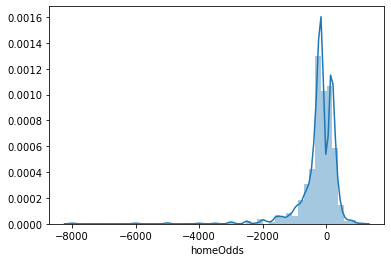

In [45]:
## home money line distribution
sns.distplot(nba_final['homeOdds'])

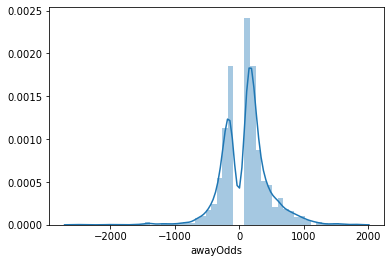

In [46]:
## away money line distribution
sns.distplot(nba_final['awayOdds'])

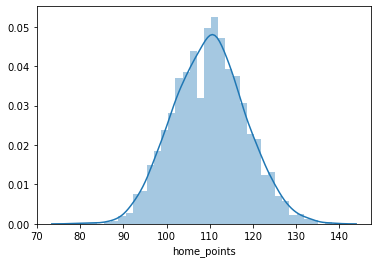

In [47]:
## points distribution
sns.distplot(nba_final['home_points'])

##### Our correlations all seem logical with the away team win total and the home team loss total being the strongest negative correlation to a home win -- essentially representing which team has had more success so far that season.

In [48]:
## get correlations to win
winCorr = nba_final.corr()['homeWin'].sort_values(ascending=False)

In [49]:
## top 10 correlations to home win
winCorr.head(10)

homeWin                                 1.000000
home_offensive_rating                   0.185224
home_true_shooting_percentage           0.156541
home_effective_field_goal_percentage    0.151229
home_points                             0.147727
away_losses                             0.142922
home_total_rebound_percentage           0.136997
home_wins                               0.131149
away_defensive_rating                   0.096225
home_three_point_attempt_rate           0.078068
Name: homeWin, dtype: float64

In [50]:
## bottom 10 correlations to home win
winCorr.tail(10)

away_three_point_field_goals    -0.083418
away_true_shooting_percentage   -0.084823
away_points                     -0.087323
away_offensive_rating           -0.088623
home_defensive_rating           -0.097847
home_blocks                     -0.120913
home_total_rebounds             -0.124455
home_defensive_rebounds         -0.127223
away_wins                       -0.138545
home_losses                     -0.203298
Name: homeWin, dtype: float64

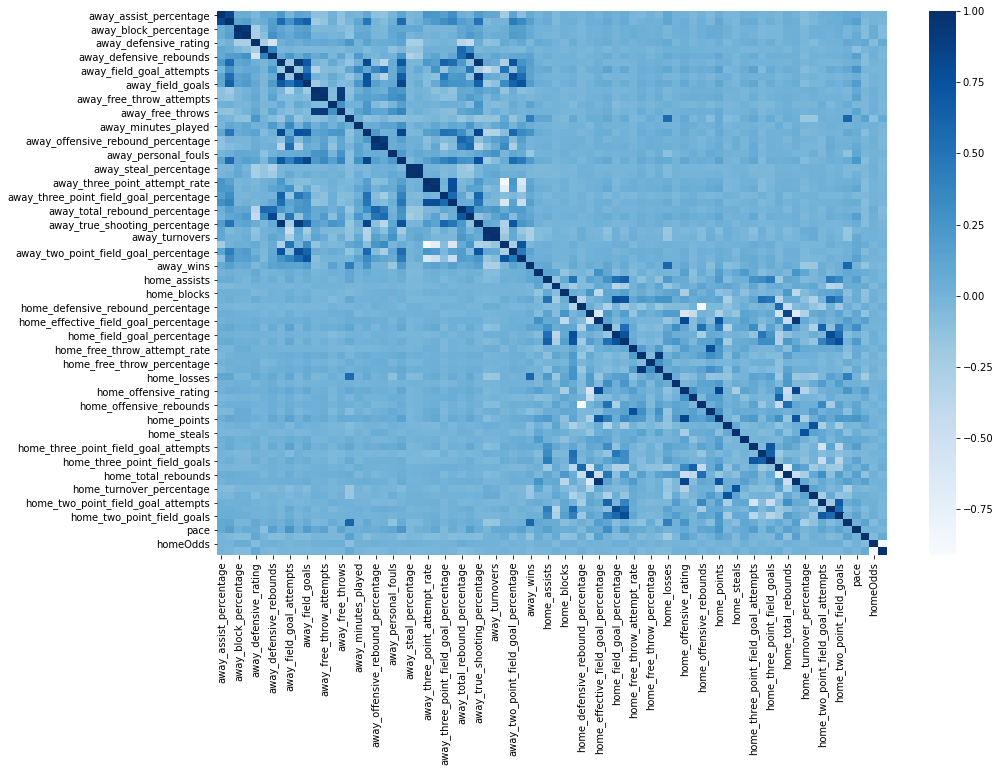

In [51]:
# Correlation heatmap
plt.subplots(figsize=(15,10))
ax = plt.axes()
corr = nba_final.corr()
sns.heatmap(corr,cmap = "Blues")

##### We have high collinearity among some of our features, mostly in cases where there's a total and a percentage value for one statistic. If we we're going to build a regression model we'd need to address this, but for our classifier, it shouldn't impact predictive performance.

In [52]:
## list of the top 25 positive correlations
top25_corr_pos = nba_final.corr().unstack().sort_values(ascending=False).drop_duplicates()
top25_corr_pos.head(25)

awayOdds                              awayOdds                                1.000000
away_steal_percentage                 away_steals                             0.984256
away_turnovers                        away_turnover_percentage                0.966290
away_free_throw_attempts              away_free_throw_attempt_rate            0.965782
home_true_shooting_percentage         home_effective_field_goal_percentage    0.964337
away_effective_field_goal_percentage  away_true_shooting_percentage           0.962943
away_three_point_field_goal_attempts  away_three_point_attempt_rate           0.955601
away_block_percentage                 away_blocks                             0.941173
home_free_throws                      home_free_throw_attempts                0.935080
away_field_goal_percentage            away_effective_field_goal_percentage    0.935055
away_free_throw_attempts              away_free_throws                        0.929422
away_offensive_rebound_percentage     away_

In [53]:
## list of the top 25 negative correlations
top25_corr_neg = nba_final.corr().unstack().sort_values().drop_duplicates()
top25_corr_neg.head(25)

home_defensive_rebound_percentage     home_offensive_rebounds                -0.910098
away_two_point_field_goal_attempts    away_three_point_attempt_rate          -0.874806
homeOdds                              awayOdds                               -0.870390
away_two_point_field_goal_attempts    away_three_point_field_goal_attempts   -0.699835
home_total_rebound_percentage         home_total_rebounds                    -0.687128
home_defensive_rebounds               home_true_shooting_percentage          -0.635123
away_two_point_field_goals            away_three_point_attempt_rate          -0.621524
away_three_point_field_goals          away_two_point_field_goal_attempts     -0.612659
home_effective_field_goal_percentage  home_defensive_rebounds                -0.603563
home_offensive_rating                 home_defensive_rebounds                -0.588364
home_three_point_field_goal_attempts  home_two_point_field_goal_attempts     -0.548963
away_defensive_rating                 away_

## Feature Selection
Here I'll scale our features and reduce dimensionality before moving on to creating models. We'll use the robust scalar from sklearn because it can deal with positive and negative numbers and is robust to outliers, both of which we'll need mostly for our money line feature.

In [54]:
## create list of features
excluded_from_avg = ['home_wins', 'home_losses', 'away_wins','away_losses','awayOdds','homeOdds']
features = away_cols + home_cols + excluded_from_avg

In [55]:
## declare features
x = nba_final[features]
## declare target variable
y = nba_final['homeWin']

In [56]:
x.shape

(2251, 76)

In [57]:
## scale the features
scaler = RobustScaler()
x_scaled = scaler.fit_transform(x)

According to our PCA below, ~35 features explain almost all of the variance. Let's keep 40 features to be safe.

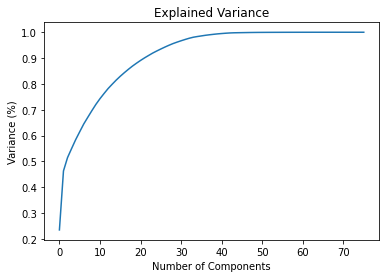

In [58]:
#Fitting the PCA algorithm with our Data
pca = PCA().fit(x_scaled)
#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('Explained Variance')
plt.show()

In [59]:
## keep 30 components
x_pca = PCA(40).fit_transform(x_scaled)

## Let's Build Some Models!
We'll compare them using the f1 score from sklearn to describe their accuracy.

In [60]:
## create our model accuracy scorer
scorer = make_scorer(f1_score, pos_label=None, average='weighted')

#### Naive Bayes

In [61]:
# Our data is continuous, so we'll use the Gaussian Classifier 
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

In [62]:
## print score
print('Average Gaussian NB F1: {}'.format((cross_val_score(gnb, x_pca, y, scoring=scorer)).mean()))

Average Gaussian NB F1: 0.6510273839589721


#### Decision Tree

In [63]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()

In [64]:
## print score
print('Average Decision Tree F1: {}'.format((cross_val_score(clf, x_pca, y, scoring=scorer)).mean()))

Average Decision Tree F1: 0.5478512615398723


#### Random Forest

In [65]:
from sklearn import ensemble
rfc = ensemble.RandomForestClassifier()

In [66]:
## print score
print('Average Random Forest F1 score: {}'.format((cross_val_score(rfc, x_pca, y, scoring=scorer)).mean()))

Average Random Forest F1 score: 0.6364343578499397


#### KNN

In [67]:
from sklearn.neighbors import KNeighborsClassifier
neighbors = KNeighborsClassifier(n_neighbors=3)

In [68]:
## print score
print('Average KNN F1 score: {}'.format((cross_val_score(neighbors, x_pca, y, scoring=scorer)).mean()))

Average KNN F1 score: 0.5553087086648063


#### Multi-layer Perceptron

In [69]:
from sklearn.neural_network import MLPClassifier

In [70]:
# Establish and fit the model, with a single, 100 perceptron layer.
mlp100 = MLPClassifier(hidden_layer_sizes=(100,))
mlp1000 = MLPClassifier(hidden_layer_sizes=(1000,))

In [71]:
## print score
print('Average MLP100 F1 score: {}'.format((cross_val_score(mlp100, x_pca, y, scoring=scorer)).mean()))

/home/sdotjr/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/sdotjr/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


Average MLP100 F1 score: 0.6506478880162315


In [ ]:
## print score
print('Average MLP1000 F1 score: {}'.format((cross_val_score(mlp1000, x_pca, y, scoring=scorer)).mean()))

/home/sdotjr/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/sdotjr/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:587: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


In [ ]:
models = ['Decision Tree', 'Neural Network','MLP','Naive Bayes','Random Forest', 'KNN']
scores = [cross_val_score(clf, x_pca, y, scoring=scorer).mean(),score[1],cross_val_score(mlp1000, x_pca, y, scoring=scorer).mean(),cross_val_score(gnb, x_pca, y, scoring=scorer).mean(),cross_val_score(neighbors, x_pca, y, scoring=scorer).mean()]

plt.barh(models,scores)

In [ ]:
scoresinstrumental

## Keras / TensorFlow Neural Network

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop
from keras import backend as K

In [ ]:
## split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.3, random_state=42)

In [ ]:
x_pca.shape

In [ ]:
# Start with a simple sequential model
model = Sequential()

# Add dense layers to create a fully connected MLP
# Note that we specify an input shape for the first layer, but only the first layer.
# Relu is the activation function used
model.add(Dense(64, activation='relu', input_shape=(40,)))
# Dropout layers remove features and fight overfitting
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.1))
# End with a number of units equal to the number of classes we have for our outcome
model.add(Dense(1, activation='softmax'))

model.summary()

# Compile the model to put it all together.
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train,
                    batch_size=128,
                    epochs=10,
                    verbose=1,
                    validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_t0.62est, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# Real World Application
Now that we have our prediction model, let's implement it to see how much hypothetical money we make! For simplicity, we'll assume we bet $100 on each prediction. This is calculated as follows:

Underdog Bet (positive odds):
 - Potential Payout = Wager Amount x (Odds/100) + Wager Amount.

Favorite Bet (negative odds):
 - Potential Payout = Wager Amount / (absolute value(Odds)/100) + Wager Amount

However, our cumulative total will only calculate profit.

In [ ]:
# declare features, scale and pca
x_test = nba_test[features]
x_test_scaled = scaler.fit_transform(x_test)
x_test_scaled_pca = PCA(40).fit_transform(x_test_scaled)

In [ ]:
# fit to training data and predict for current season
nba_test['predictions'] = gnb.fit(x_pca, y).predict(x_test_scaled_pca)

Here our model correctly picked 56% of games from the current 2019-20 season. Next we'll calculate money made.

In [ ]:
## correct pct picks
len(nba_test[nba_test['predictions']==nba_test['homeWin']])/len(nba_test)

In [ ]:
## create an empty money won column
nba_test['moneyWon'] = 0

In [ ]:
## calculate money won
##If the American odds are positive the formula is as follows: (American odds / 100) + 1 = decimal odds.
##If the American odds are negative, the formula is as follows: 1 - (100 / - American odds) = decimal odds.
for i in nba_test.index:
  ## check for correct pick
  if nba_test['predictions'].iloc[i] == nba_test['homeWin'].iloc[i]:
    ## correct home win
    if nba_test['homeWin'].iloc[i] == True:
      ## home is favored
      if nba_test['homeOdds'].iloc[i] < 0:
        nba_test.at[i, 'moneyWon'] = (100 / ((abs(nba_test['homeOdds'].iloc[i]))*100))
      ## home is underdog
      elif nba_test['homeOdds'].iloc[i] > 0:
        nba_test.at[i, 'moneyWon'] = (100 * ((nba_test['homeOdds'].iloc[i])/100))
      ## even odds
      elif nba_test['homeOdds'].iloc[i] == 0:
        nba_test.at[i, 'moneyWon'] = 100
    ## correct away win
    if nba_test['homeWin'].iloc[i] == False:
      ## away is favored
      if nba_test['awayOdds'].iloc[i] < 0:
        nba_test.at[i, 'moneyWon'] = (100 / ((abs(nba_test['awayOdds'].iloc[i]))*100)) 
      ## away is underdog
      elif nba_test['awayOdds'].iloc[i] > 0:
        nba_test.at[i, 'moneyWon'] = (100 * ((nba_test['awayOdds'].iloc[i])/100)) 
      ## even odds
      elif nba_test['awayOdds'].iloc[i] == 0:
        nba_test.at[i, 'moneyWon'] = 100 
  ## incorrect pick
  elif nba_test['predictions'].iloc[i] != nba_test['homeWin'].iloc[i]:
    nba_test.at[i, 'moneyWon'] = -100

In [ ]:
(100 / ((abs(-1100))/100))

In [ ]:
## create cumulative money won column
nba_test['cumTotalWon']  = nba_test['moneyWon'].cumsum()

In [ ]:
# check work
nba_test[['predictions','homeWin','homeOdds','awayOdds','moneyWon','cumTotalWon']].tail(10)

In [ ]:
nba_test[nba_test['predictions']==nba_test['homeWin']]['moneyWon'].sum()

In [ ]:
nba_test[nba_test['predictions']!=nba_test['homeWin']]['moneyWon'].sum()

In [ ]:
nba_test['moneyWon'].describe()

In [ ]:
import random
import n

In [ ]:
nba_rand = nba_test.copy()

In [ ]:
def random_profit(nba_test,samples = 5000):
    profits = []
    for i in range(samples):
        nba_rand = nba_test.copy()
        nba_rand['predictions'] = np.random.randint(0,2,size=len(nba_test)).astype(bool)
        calc_money(nba_rand)
        profits.append(nba_rand['cumTotalWon'][589])
    return profits

In [ ]:
rands = random_profit(nba_test)

In [ ]:
np.array(rands).mean()

In [ ]:
plt.hist(rands)
plt.axvline(np.array(rands).mean(),color='b')
plt.

In [ ]:
nba_home = nba_test.copy()

In [ ]:
nba_away = nba_test.copy()

In [ ]:
nba_rand['predictions'] = np.random.randint(0,2,size=len(nba_test)).astype(bool)
nba_home['predictions'] = np.full(len(nba_test),1).astype(bool)
nba_away['predictions'] = np.full(len(nba_test),0).astype(bool)

In [ ]:
def calc_money(nba_test): 
    for i in nba_test.index:
      ## check for correct pick
      if nba_test['predictions'].iloc[i] == nba_test['homeWin'].iloc[i]:
        ## correct home win
        if nba_test['homeWin'].iloc[i] == True:
          ## home is favored
          if nba_test['homeOdds'].iloc[i] < 0:
            nba_test.at[i, 'moneyWon'] = (100 / ((abs(nba_test['homeOdds'].iloc[i]))*100))
          ## home is underdog
          elif nba_test['homeOdds'].iloc[i] > 0:
            nba_test.at[i, 'moneyWon'] = (100 * ((nba_test['homeOdds'].iloc[i])/100))
          ## even odds
          elif nba_test['homeOdds'].iloc[i] == 0:
            nba_test.at[i, 'moneyWon'] = 100
        ## correct away win
        if nba_test['homeWin'].iloc[i] == False:
          ## away is favored
          if nba_test['awayOdds'].iloc[i] < 0:
            nba_test.at[i, 'moneyWon'] = (100 / ((abs(nba_test['awayOdds'].iloc[i]))*100)) 
          ## away is underdog
          elif nba_test['awayOdds'].iloc[i] > 0:
            nba_test.at[i, 'moneyWon'] = (100 * ((nba_test['awayOdds'].iloc[i])/100)) 
          ## even odds
          elif nba_test['awayOdds'].iloc[i] == 0:
            nba_test.at[i, 'moneyWon'] = 100 
      ## incorrect pick
      elif nba_test['predictions'].iloc[i] != nba_test['homeWin'].iloc[i]:
        nba_test.at[i, 'moneyWon'] = -100
        
    nba_test['cumTotalWon']  = nba_test['moneyWon'].cumsum()

In [ ]:
calc_money(nba_away)

In [ ]:
calc_money(nba_rand)

In [ ]:
calc_money(nba_home)

In [ ]:
nba_rand['cumTotalWon'] = nba_rand.moneyWon.astype(float).cumsum()

In [ ]:
nba_rand

In [ ]:
nba_away

In [ ]:
nba_test.winner.value_counts()

In [ ]:
plt.hist(nba_test.homeOdds)
plt.title('Home Odds',fontdict=font,size=20,pad=10)
plt.axvline(nba_test.homeOdds.mean(),color='blue',alpha=.5,linestyle='dashdot',label=f'Mean: {round(nba_test.homeOdds.mean())}')
plt.legend()
plt.savefig('imgs/homeodds.png')

In [ ]:
-100*(319) + 100*(271)

In [ ]:
plt.hist(nba_test.awayOdds,color='blue')
plt.title('Away Odds',fontdict=font,size=20,pad=10)
plt.axvline(nba_test.awayOdds.mean(),color='orange',alpha=.5,linestyle='dashdot',label=f'Mean: +{round(nba_test.awayOdds.mean())}')
plt.legend()
plt.savefig('imgs/awayodds.png')

In [ ]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 16,
        }

labels = 'Home','Away'
sizes = [15, 30, 45, 10]
explode = (0, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
ax1.pie(nba_test.winner.value_counts(), explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Wins',fontdict=font,size=20)
plt.savefig('imgs/winsbyloc.png')

In [ ]:
nba_test.groupby(['homeTeam'])['moneyWon'].sum().plot.barh(figsize=(20,16),color=['firebrick','darkgreen','black','red','lightseagreen','maroon','navy','midnightblue','crimson','gold','red','goldenrod','blue','darkviolet','darkturquoise','darkred','darkgreen','skyblue','navy','darkorange','deepskyblue','blue','red','darkorchid','black','purple','black','darkred','navy','mediumblue'])

In [ ]:
earningsbyTeam = nba_test.groupby(['homeTeam'])['moneyWon'].sum()

In [ ]:
earnings = pd.Series(earningsbyTeam)

In [ ]:
color=['firebrick','darkgreen','black','red','lightseagreen','maroon','navy','midnightblue','crimson','gold','red','goldenrod','blue','darkviolet','darkturquoise','darkred','darkgreen','skyblue','navy','darkorange','deepskyblue','blue','red','darkorchid','red','purple','black','darkred','navy','mediumblue']

In [ ]:
colorSeries = pd.Series(color,name='color',index=earnings.index)

In [ ]:
nba_test.tail(20)

In [ ]:
earningsbyTeam2 = pd.merge(earnings,colorSeries,left_index=True,right_index=True)

In [ ]:
import os

images = []

folder = 'logos/'
for fn in os.listdir(folder):
    images.append(fn)

In [ ]:
earn = earningsbyTeam2.sort_values('moneyWon')

In [ ]:
earn

In [ ]:
nba_test

In [ ]:
import matplotlib.image as mpimg


def pos_image(x, y, im, haut):
    path = "logos"
    newim = f"{path}/{im}"
    newim = mpimg.imread(newim)
    ratio = 4 / 3
    w = ratio * haut
    ax.imshow(newim,
              extent=(x - w, x, y, y + haut),
              zorder=2)


In [ ]:
fig, ax = plt.subplots(figsize=(16,12))
r = ax.barh(earn.index,width=earn.moneyWon,height=1,color=earn.color)
r
y_bar = [rectangle.get_y() for rectangle in r]
ax.axvline(0,color='black',linestyle='--')
ax.set_title('Profit by Team',size=30,pad=15)
ax.set_xlabel('Profit ($)',size=18,labelpad=10)
ax.set_ylabel('Team',size=18,labelpad=10)
ax.set_facecolor('white')
plt.savefig('imgs/profitbyteam.jpg')



# Final Results!

In [ ]:
## plot the cumulative money won over time
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(nba_test['date'], nba_test['cumTotalWon'],color=(nba_test['cumTotalWon'] > 0).map({True: 'g',
                                                    False: 'r'}))
plt.plot(nba_test['date'], nba_test['cumTotalWon'],color=[0, 0.4470, 0.7410],alpha=0.6)
plt.title('Cumulative Earnings with $100 bets',fontsize=24,pad=20)
plt.ylabel('Dollars Earned ($)')
plt.xlabel('2019-20 NBA Season',labelpad=20,fontsize=15)
plt.grid(linestyle='-',alpha=.2)
ax.tick_params()
plt.savefig('imgs/cumearnings.png')

In [ ]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(nba_home['date'], nba_home['cumTotalWon'],color=(nba_home['cumTotalWon'] > 0).map({True: 'g',
                                                    False: 'r'}))
plt.plot(nba_home['date'], nba_home['cumTotalWon'],color=[0, 0.4470, 0.7410],alpha=0.6)
plt.title('Cumulative Earnings with $100 bets',fontsize=24,pad=20)
plt.ylabel('Dollars Earned ($)')
plt.xlabel('2019-20 NBA Season',labelpad=20,fontsize=15)
plt.grid(linestyle='-',alpha=.2)
ax.tick_params()
#plt.savefig('imgs/homeearnings.png')

In [ ]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(14,8))
plt.scatter(nba_away['date'], nba_away['cumTotalWon'],color=(nba_away['cumTotalWon'] > 0).map({True: 'g',
                                                    False: 'r'}))
plt.plot(nba_away['date'], nba_away['cumTotalWon'],color=[0, 0.4470, 0.7410],alpha=0.6)
plt.title('Cumulative Earnings with $100 bets',fontsize=24,pad=20)
plt.ylabel('Dollars Earned ($)')
plt.xlabel('2019-20 NBA Season',labelpad=20,fontsize=15)
plt.grid(linestyle='-',alpha=.2)
plt.bar(nba_test5000.index,nba_test5000.cumTotalWon)
ax.tick_params()
#plt.savefig('imgs/homeearnings.png')

In [ ]:
nba_test5000 = nba_test.copy()
nba_test5000['cumTotalWon'] += 2000
plt.bar(nba_test5000.index,nba_test5000.cumTotalWon)

In [ ]:
(-100)*(319) + (100)*(520-319)

In [ ]:
print("The model's low point is {} dollars.".format(nba_test['cumTotalWon'].min()))
print("The model's high point is {} dollars.".format(nba_test['cumTotalWon'].max()))
print("The model has profited {} dollars this season.".format(nba_test['cumTotalWon'].iloc[-1]))

Below are a few predicted huge upsets! 

In [ ]:
## top 5 wins
nba_test[['date','homeTeam','awayTeam','predictions','homeWin','homeOdds','awayOdds','moneyWon']].loc[nba_test['moneyWon'] > 100].sort_values(by='moneyWon',ascending=False).head()

Here's some potentially dumb bets that we still got right.

In [ ]:
## least money made on a bet
nba_test[['date','homeTeam','awayTeam','predictions','homeWin','homeOdds','awayOdds','moneyWon']].loc[nba_test['moneyWon'] > 0].sort_values(by='moneyWon').head()

In [ ]:
nba_test.homeOdds.describe()

In [ ]:
from scipy.stats import norm

In [ ]:
norm.normal